In [1]:
from distmesh import *
from FEM_TPT import *
import numpy as np
import math
import matplotlib.pyplot as plt
import csv 
import pandas as pd

In [4]:
# finds the committor, the reactive current, and the reaction rate for the face potential 
# using the finite element method and the distmesh triangulation

# the committor equation 

# \nabla \cdot (\exp( - \beta fpot(x) \nabla q(x) ) = 0, x \in (A\cup B)^c
# q(\partial A) = 0, q(\partial B) = 1
# dq/dn = 0, x \in outer boundaty defined by {x : fpot(x) = Vbdry}

# the homogeneous Neumann boundary condition dq/dn = 0 means that 
# the trajectory reflects from the outer boundary whenever it reaches it

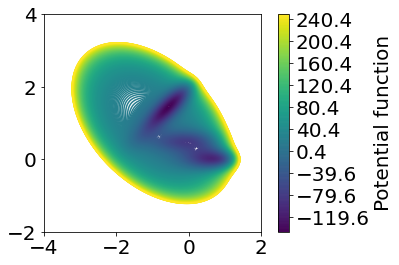

In [5]:
# parameters for Mueller's potential
xa=-0.558
ya=1.441 
xb=0.623 
yb=0.028

# problem setup: choose sets A and B and the outer boundary
# set A is the circle with center at (xa,ya) and radius ra
# set B is the circle with center at (xb,yb) and radius rb
ra = 0.1 # radius of set A
rb = 0.1 # radius of set B
beta = 0.5 # beta = 1/(k_B T), T = temperature, k_B = Boltzmann's constant
Vbdry = 250 # level set of the outer boundary {x : fpot(x) = Vbdry}

# if generate_mesh = True, mesh is generated and saved as csv files
# if generate_mesh = False, mesh is downloaded from those csv files
generate_mesh = True

# h0 is the desired scaling parameter for the mesh
h0 = 0.05


def mueller(x):
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    D = np.array([-200,-100,-170,15])
    X = np.array([1,0,-0.5,-1])
    Y = np.array([0,0.5,1.5,1])
  
    fx1 = D[0]*np.exp(a[0]*((x[:,0]-X[0])**(2)) + b[0]*(x[:,0]-X[0])*(x[:,1]-Y[0]) + c[0]*((x[:,1]-Y[0])**(2)))
    fx2 = D[1]*np.exp(a[1]*((x[:,0]-X[1])**(2)) + b[1]*(x[:,0]-X[1])*(x[:,1]-Y[1]) + c[1]*((x[:,1]-Y[1])**(2)))
    fx3 = D[2]*np.exp(a[2]*((x[:,0]-X[2])**(2)) + b[2]*(x[:,0]-X[2])*(x[:,1]-Y[2]) + c[2]*((x[:,1]-Y[2])**(2)))
    fx4 = D[3]*np.exp(a[3]*((x[:,0]-X[3])**(2)) + b[3]*(x[:,0]-X[3])*(x[:,1]-Y[3]) + c[3]*((x[:,1]-Y[3])**(2)))
    
    U = fx1+fx2+fx3+fx4
    return U

# define the potential on a meshgrid

#changed here for square grid
nx,ny= (120,120)
nxy = nx*ny
xmin = -4.0
xmax = 2.0
ymin = -2
ymax = 4
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax ,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))
v = np.zeros(nxy)
xy = np.concatenate((x_vec,y_vec),axis=1)
v = mueller(xy)
vmin = np.amin(v)
v_grid = np.reshape(v,(nx,ny))    
# graphics
plt.rcParams.update({'font.size': 20})
ls = plt.contour(x_grid,y_grid,v_grid,np.arange(vmin,Vbdry,1))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)


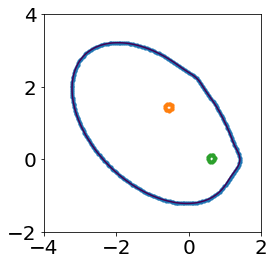

In [6]:
# set sets A and B and the outer boundary
Na = int(round(2*math.pi*ra/h0))
Nb = int(round(2*math.pi*rb/h0))
ptsA = put_pts_on_circle(xa,ya,ra,Na)
ptsB = put_pts_on_circle(xb,yb,rb,Nb)

# outer boundary
bdrydata = plt.contour(x_grid,y_grid,v_grid,[Vbdry]) # need this for the meshing
for item in bdrydata.collections:
    for i in item.get_paths():
        p_outer = i.vertices
# reparametrize the outer boundary to make the distance 
# between the nearest neighbor points along it approximately h0
pts_outer = reparametrization(p_outer,h0);

Nouter = np.size(pts_outer,axis=0)
Nfix = Na+Nb+Nouter

plt.scatter(pts_outer[:,0],pts_outer[:,1],s=10)
plt.scatter(ptsA[:,0],ptsA[:,1],s=10)
plt.scatter(ptsB[:,0],ptsB[:,1],s=10)
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})


count =  200 displacement =  0.013194157618633176
count =  400 displacement =  0.00564118254096753
Npts =  6776  Ntri =  13268


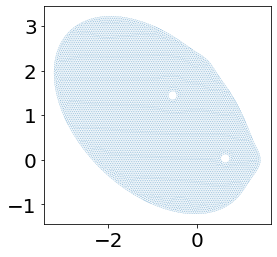

In [7]:
# input data for triangulation
# bbox = [xmin,xmax,ymin,ymax]
if generate_mesh == True:
    bbox = [xmin,xmax,ymin,ymax]
    pfix = np.zeros((Nfix,2))
    pfix[0:Na,:] = ptsA
    pfix[Na:Na+Nb,:] = ptsB
    pfix[Na+Nb:Nfix,:] = pts_outer

    def dfunc(p):
        d0 = mueller(p)
        dA = dcircle(p,xa,ya,ra)
        dB = dcircle(p,xb,yb,rb)
        d = ddiff(d0-Vbdry,dunion(dA,dB))
        return d

    pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)
    with open('mueller_pts.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(pts)

    with open('mueller_tri.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(tri)
else:
    pts = np.loadtxt('mueller_pts.csv', delimiter=',', dtype=float)
    tri = np.loadtxt('mueller_tri.csv', delimiter=',', dtype=int)

Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)
print("Npts = ",Npts," Ntri = ",Ntri)    

In [76]:
# find the mesh points lying on the Dirichlet boundary \partial A \cup \partial B
NAind,Aind = find_ABbdry_pts(pts,xa,ya,ra,h0) # find mesh points on \partial A
NBind,Bind = find_ABbdry_pts(pts,xb,yb,rb,h0) # find mesh points on \partial B

# find the committor
q = FEM_committor_solver(pts,tri,Aind,Bind,mueller, 0.16666667)



C:\Users\willi\Desktop\UMD REU\mueller\FEM_TPT.py:137: LinAlgWarning: Ill-conditioned matrix (rcond=5.88795e-29): result may not be accurate.
  q[free_nodes] = scipy.linalg.solve(A[free_nodes_t,free_nodes],b[free_nodes])


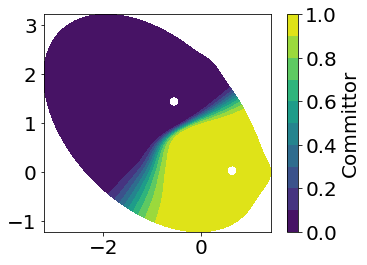

In [77]:
# visualize the committor
# np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.tricontourf(pts[:,0], pts[:,1],tri,q, np.linspace(0, 1, 11))
plt.colorbar(label="Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('mueller_committor.pdf')



In [ ]:
iters = 100
betaspace = np.linspace(.05, .2, iters)
betastorage = np.zeros((iters, 6776))
qstorage = np.zeros((iters, 6776))


for i in range(iters): 
    print(betaspace[i])
    betastorage[i, :] = betaspace[i] + np.zeros((1, 6776))
    qstorage[i, :] = FEM_committor_solver(pts,tri,Aind,Bind,mueller,betaspace[i])


In [54]:
qdf = pd.DataFrame(qstorage)
qdf.to_csv("committorsFEM.csv", index = False)
bdf = pd.DataFrame(betastorage)
bdf.to_csv("betasFEM.csv", index = False)


In [117]:
pts[:, 0]

array([-3.2178127 , -3.21761295, -3.21663807, ...,  1.40716196,
        1.41013492,  1.41220077])

In [120]:
q

array([2.87257727e-04, 2.79833203e-04, 2.93438648e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

Npts =  27  Ntri =  39
Npts =  27  Ntri =  39
Z =  [124281.96427262]


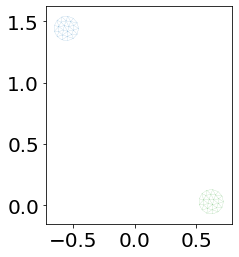

In [7]:
def dfuncA(p):
    return dcircle(p,xa,ya,ra)

def dfuncB(p):
    return dcircle(p,xb,yb,rb)
bbox = [xa-ra,xa+ra,ya-ra,ya+ra]
pts_Amesh,tri_Amesh = distmesh2D(dfuncA,huniform,h0,bbox,ptsA)
bbox = [xb-rb,xb+rb,yb-rb,yb+rb]
pts_Bmesh,tri_Bmesh = distmesh2D(dfuncB,huniform,h0,bbox,ptsB)

Npts_Amesh = np.size(pts_Amesh,axis=0)
Ntri_Amesh = np.size(tri_Amesh,axis=0)
print("Npts = ",Npts_Amesh," Ntri = ",Ntri_Amesh) 

Npts_Bmesh = np.size(pts_Bmesh,axis=0)
Ntri_Bmesh = np.size(tri_Bmesh,axis=0)
print("Npts = ",Npts_Bmesh," Ntri = ",Ntri_Bmesh) 
                         
Z = invariant_pdf(pts,tri,pts_Amesh,tri_Amesh,pts_Bmesh,tri_Bmesh,mueller,beta)
print("Z = ",Z)

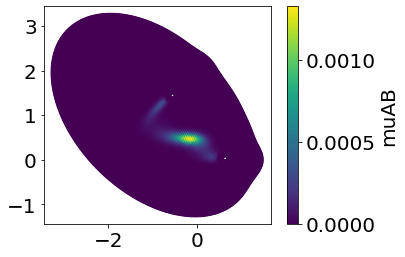

In [8]:
# probability density of reactive trajectories
mu = np.exp(-beta*mueller(pts))/Z
muAB = mu*q*(1-q)
plt.scatter(pts[:,0], pts[:,1],c = muAB)
#plt.scatter(pts[:,0],pts[:,1],c=q)
plt.colorbar(label="muAB", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('mueller_muAB.pdf')


In [9]:
# find the reactive current and the transition rate
Rcurrent, Rrate = reactive_current_and_transition_rate(pts,tri,mueller,beta,q,Z)
print("Transition rate = ",Rrate)

Transition rate =  [0.00492646]


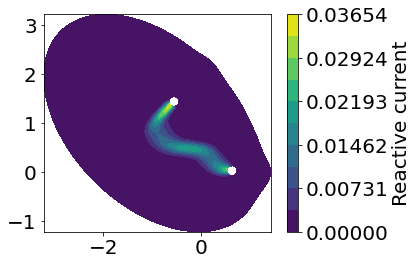

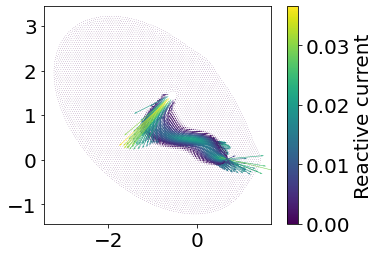

In [10]:
# visualize the reactive current
# find the absolute value of the reactive current
ARcurrent = np.linalg.norm(Rcurrent,axis = 1)
ARCmax = np.amax(ARcurrent)
plt.tricontourf(pts[:,0], pts[:,1],tri,ARcurrent,np.linspace(0,ARCmax,11))
plt.colorbar(label="Reactive current", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('mueller_rcurrent.pdf')
plt.show()

plt.quiver(pts[:,0],pts[:,1],Rcurrent[:,0],Rcurrent[:,1],ARcurrent)
plt.colorbar(label="Reactive current", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
# plt.savefig('mueller_rcurrent_dir.pdf')

In [11]:
# # save the mesh point, the committor, and the reactive current
# TPTdata = np.concatenate((pts,np.reshape(q,(Npts,1)),Rcurrent),axis = 1)
# with open('mueller_TPTdata.csv', 'w', newline='') as file:
#     mywriter = csv.writer(file, delimiter=',')
#     mywriter.writerows(TPTdata)

In [12]:
# p = np.array([0.1,0.1])
# def find_nearest_neighbor(p,pts):
#     dist2 = (pts[:,0]-p[0])**2 + (pts[:,1]-p[1])**2
#     jmin = np.where(dist2 == np.amin(dist2))   
#     return jmin

# jmin = np.reshape(find_nearest_neighbor(p,pts),(1,))[0]
# print(jmin)
# print(np.sqrt((pts[jmin,0]-p[0])**2 + (pts[jmin,1]-p[1])**2))




In [13]:
# find the probability that a trajectory is reactive at any randomly picked time t
# \rho_{AB} = \int_{\Omega_{AB}}\mu*qplus*qminus*dx
prob_reactive = probability_reactive(pts,tri,mueller,beta,q,Z)
print("Probability that a trajectory is reactive at a randomly picked time: ",prob_reactive)

Probability that a trajectory is reactive at a randomly picked time:  [0.00023674]


In [14]:
# find the probability that a trajectory is reactive at any randomly picked time t
# \rho_{A} = \int_{\Omega}\mu*qminus*dx
prob_lastA = probability_last_A(pts,tri,pts_Amesh,tri_Amesh,mueller,beta,q,Z)
print("Probability that a trajectory last visited A: ",prob_lastA)

Probability that a trajectory last visited A:  [0.97458698]
